In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import plot_model
from IPython.display import Image


In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Vanilla autoencoders

In [ ]:
# Function to load images from folder and convert to grayscale arrays
def load_images_from_folder(folder_path, image_size=(224, 224)):
    images = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        try:
            img = load_img(img_path, target_size=image_size, color_mode='grayscale')
            img_array = img_to_array(img).astype('float32') / 255.0  # Normalize
            images.append(img_array)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
    return images

# Define dataset path
dataset_path = '/content/drive/MyDrive/OS Collected Data/sample/Training'

# Load images from all classes
all_images = []
for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)
    if os.path.isdir(class_path):
        all_images.extend(load_images_from_folder(class_path))

# Convert to numpy array
X = np.array(all_images)

# Flatten for Dense input
X_flat = X.reshape((len(X), -1))

# Split into train and test sets
X_train, X_test = train_test_split(X_flat, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (1245, 50176)
X_test shape: (312, 50176)


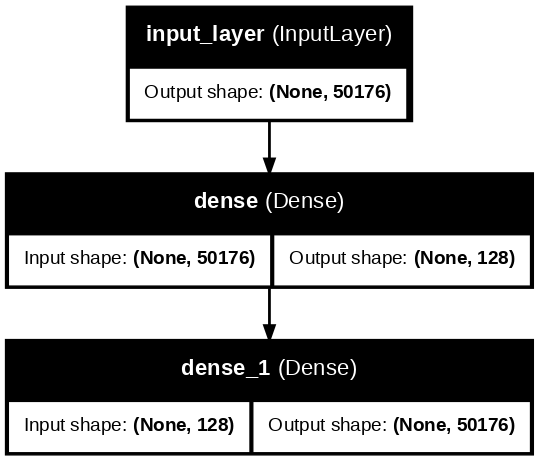

In [ ]:
# Autoencoder settings
input_size = X_train.shape[1]  # should be 224*224 = 50176
hidden_size = 128  # adjustable
output_size = input_size

# Build model
x = Input(shape=(input_size,))
h = Dense(hidden_size, activation='relu')(x)
r = Dense(output_size, activation='sigmoid')(h)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adam', loss='mse')

# Visualize model
plot_model(autoencoder, to_file='model_plot.png', show_shapes=True, show_layer_names=True, dpi=100)
Image('model_plot.png')


In [ ]:
epochs = 10
batch_size = 32

history = autoencoder.fit(
    X_train, X_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, X_test)
)


Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 15s 333ms/step - loss: 0.0753 - val_loss: 0.0235
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 15s 197ms/step - loss: 0.0214 - val_loss: 0.0176
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 215ms/step - loss: 0.0168 - val_loss: 0.0154
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 238ms/step - loss: 0.0139 - val_loss: 0.0135
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step - loss: 0.0126 - val_loss: 0.0122
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 209ms/step - loss: 0.0111 - val_loss: 0.0113
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 243ms/step - loss: 0.0103 - val_loss: 0.0109
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 221ms/step - loss: 0.0096 - val_loss: 0.0102
Epoch 9/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 229ms/step - loss: 0.0091 - val_loss: 0.0096
Epoch 10/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 13s 296ms/step - loss: 0.0087 - val_loss: 0.0095


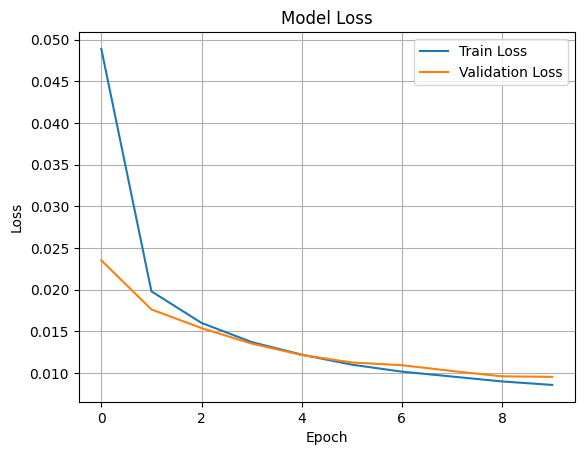

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


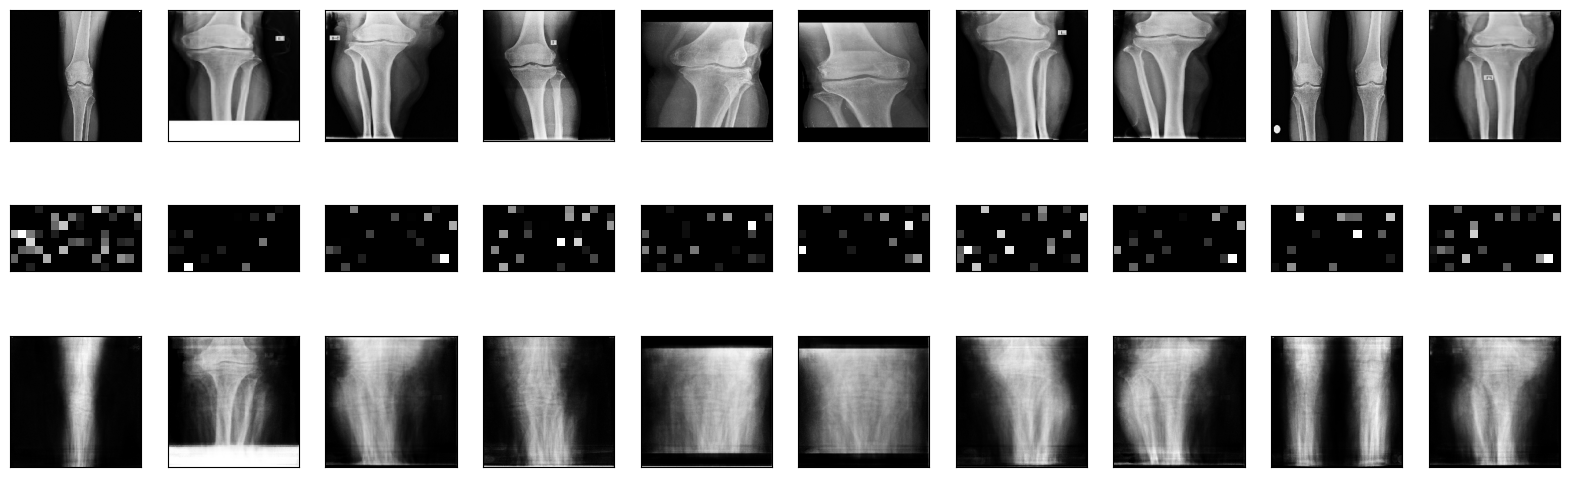

In [ ]:
# Create encoder model
encoder = Model(inputs=x, outputs=h)
encoded_imgs = encoder.predict(X_test)

# Decode
decoded_imgs = autoencoder.predict(X_test)

# Display results
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # Original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(X_test[i].reshape(224, 224), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Encoded representation
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(encoded_imgs[i].reshape(8, -1), cmap='gray')  # Rough reshape for visualization
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstruction
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i].reshape(224, 224), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()


Multilayer autoencoder

In [ ]:

def load_images_from_folder(folder_path, image_size=(224, 224)):
    images = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        try:
            img = load_img(img_path, target_size=image_size, color_mode='grayscale')
            img_array = img_to_array(img).astype('float32') / 255.0
            images.append(img_array)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
    return images

dataset_path = '/content/drive/MyDrive/OS Collected Data/sample/Training'

all_images = []
for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)
    if os.path.isdir(class_path):
        all_images.extend(load_images_from_folder(class_path))

X = np.array(all_images)
X_flat = X.reshape((len(X), -1))  # Flatten for Dense layers

X_train, X_test = train_test_split(X_flat, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (1245, 50176)
X_test shape: (312, 50176)


In [ ]:
input_size = X_train.shape[1]  # 224*224 = 50176
encoding_dim1 = 1024
encoding_dim2 = 256
bottleneck_dim = 64

# Encoder
input_layer = Input(shape=(input_size,))
encoded = Dense(encoding_dim1, activation='relu')(input_layer)
encoded = Dense(encoding_dim2, activation='relu')(encoded)
bottleneck = Dense(bottleneck_dim, activation='relu')(encoded)

# Decoder
decoded = Dense(encoding_dim2, activation='relu')(bottleneck)
decoded = Dense(encoding_dim1, activation='relu')(decoded)
output_layer = Dense(input_size, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')


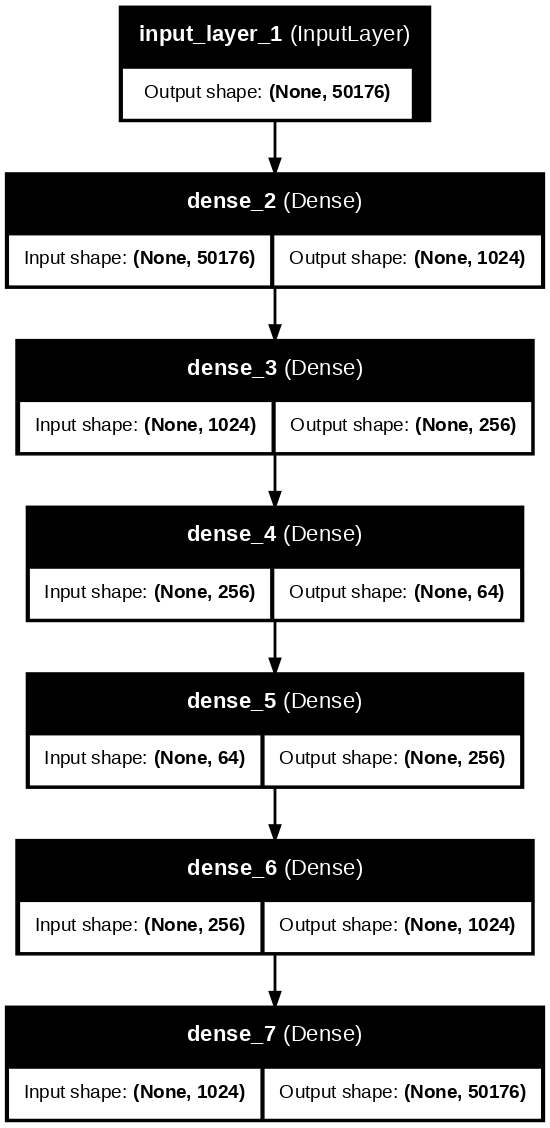

In [ ]:
plot_model(autoencoder, to_file='multi_layer_autoencoder.png', show_shapes=True, show_layer_names=True, dpi=100)
Image('multi_layer_autoencoder.png')


In [ ]:
epochs = 10
batch_size = 32

history = autoencoder.fit(
    X_train, X_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, X_test)
)


Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - loss: 0.0740 - val_loss: 0.0261
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - loss: 0.0239 - val_loss: 0.0190
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - loss: 0.0173 - val_loss: 0.0162
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - loss: 0.0148 - val_loss: 0.0148
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - loss: 0.0133 - val_loss: 0.0137
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - loss: 0.0121 - val_loss: 0.0123
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - loss: 0.0109 - val_loss: 0.0119
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - loss: 0.0100 - val_loss: 0.0108
Epoch 9/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - loss: 0.0093 - val_loss: 0.0104
Epoch 10/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 157s 3s/step - loss: 0.0086 - val_loss: 0.0098


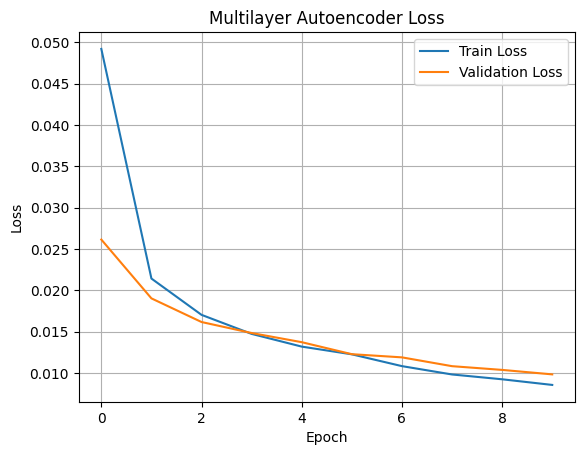

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Multilayer Autoencoder Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step


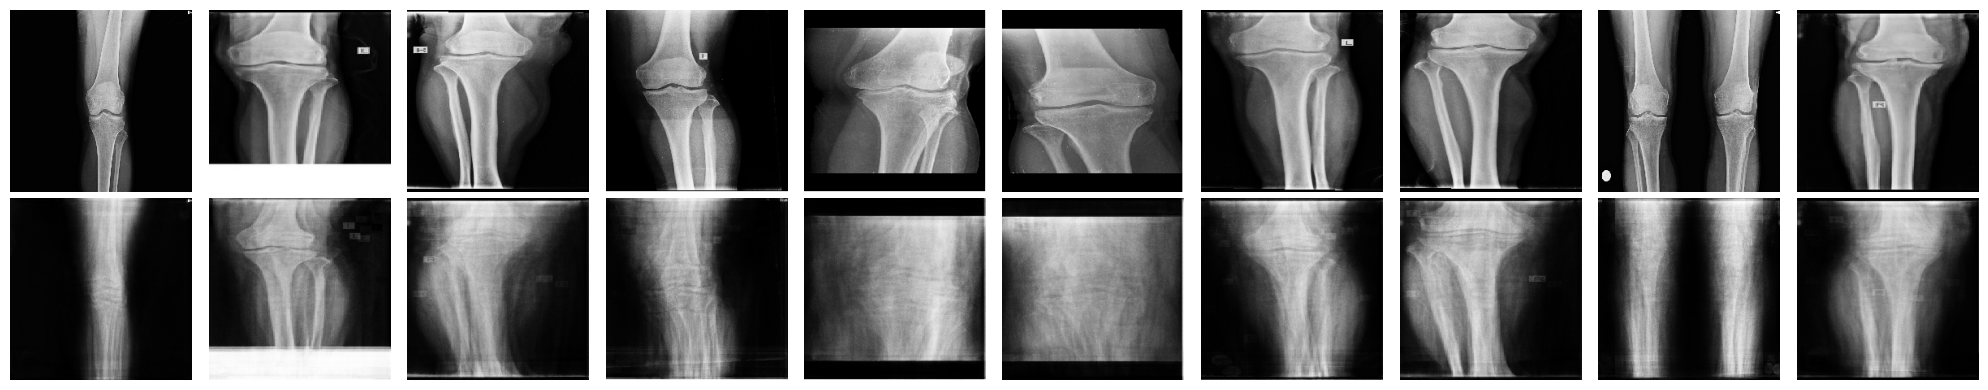

In [ ]:
decoded_imgs = autoencoder.predict(X_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(224, 224), cmap='gray')
    ax.axis('off')

    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(224, 224), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()


Convolutional autoencoder

In [ ]:
# Function to load images
def load_images_from_folder(folder_path, image_size=(224, 224)):
    images = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        try:
            img = load_img(img_path, target_size=image_size, color_mode='grayscale')
            img_array = img_to_array(img) / 255.0  # Normalize
            images.append(img_array)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
    return images

# Set the path
dataset_path = '/content/drive/MyDrive/OS Collected Data/sample/Training'

# Load all images
all_images = []
for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)
    if os.path.isdir(class_path):
        imgs = load_images_from_folder(class_path)
        all_images.extend(imgs)

# Convert to numpy array
X = np.array(all_images)

# Split into train and test sets
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Print shape
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)


X_train shape: (1245, 224, 224, 1)
X_test shape: (312, 224, 224, 1)


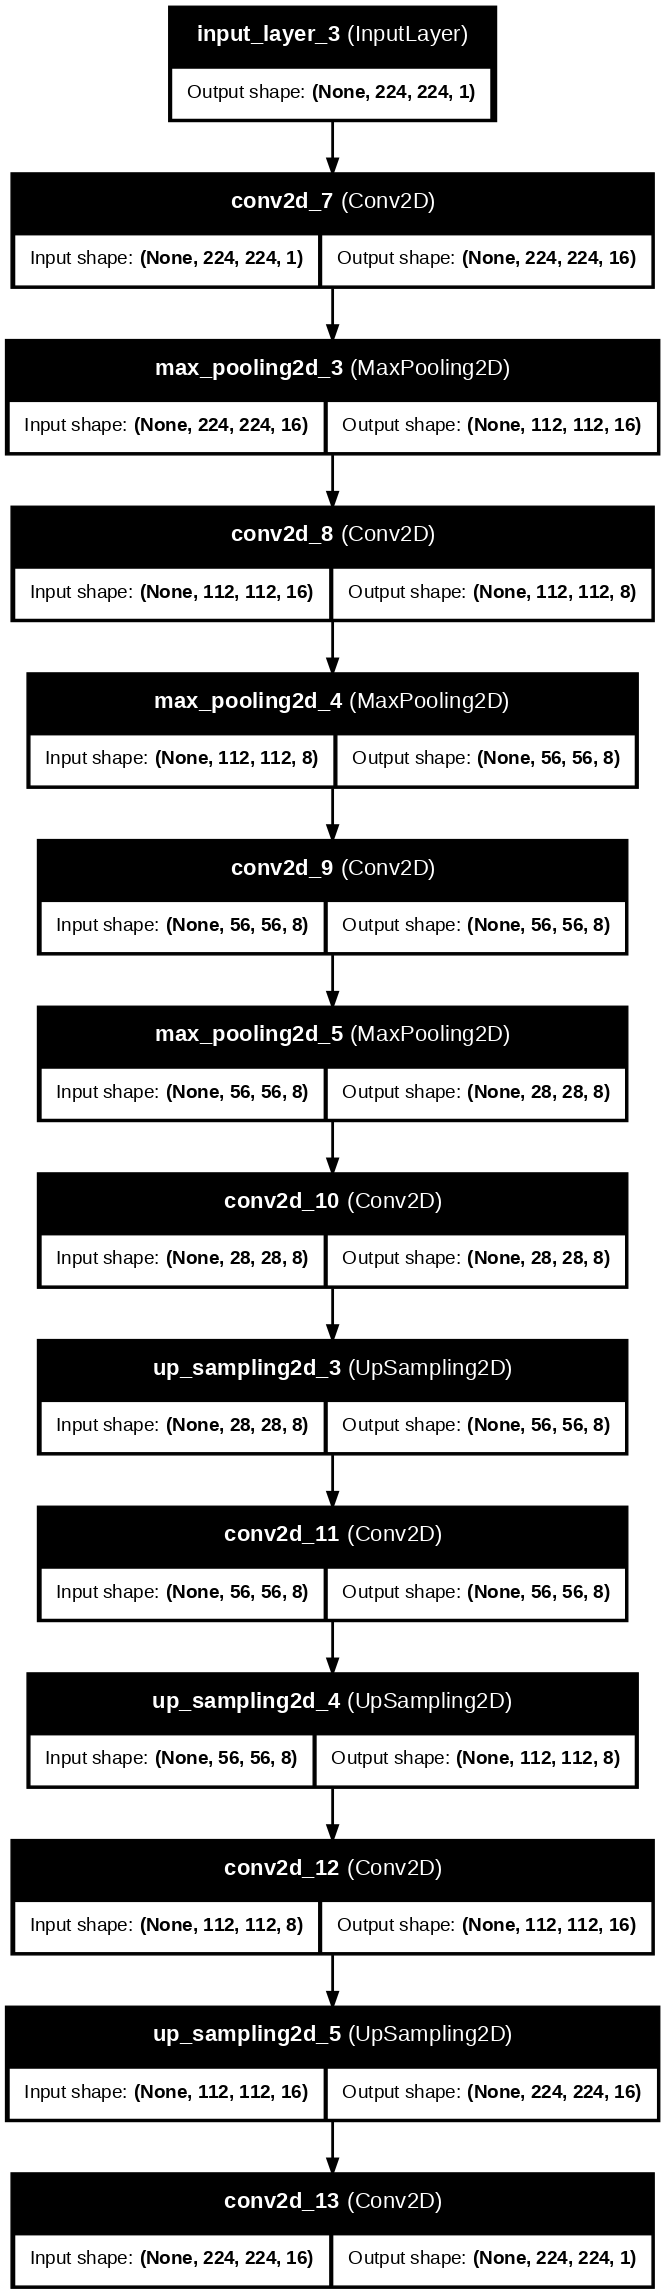

In [ ]:
# Input layer
input_img = Input(shape=(224, 224, 1))

# Encoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x) # Add padding='same' here
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Compile model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

# Model Summary Plot
plot_model(autoencoder, to_file='model_plot.png', show_shapes=True, show_layer_names=True, dpi=100)

# Display Model Plot
Image('model_plot.png')

In [ ]:
# Set parameters
epochs = 20
batch_size = 32

# Fit the model
history = autoencoder.fit(
    X_train, X_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, X_test)
)


Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - loss: 0.6930 - val_loss: 0.6930
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - loss: 0.6930 - val_loss: 0.6929
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - loss: 0.6929 - val_loss: 0.6929
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - loss: 0.6929 - val_loss: 0.6928
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - loss: 0.6928 - val_loss: 0.6927
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - loss: 0.6927 - val_loss: 0.6926
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - loss: 0.6926 - val_loss: 0.6925
Epoch 8/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - loss: 0.6925 - val_loss: 0.6924
Epoch 9/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - loss: 0.6924 - val_loss: 0.6923
Epoch 10/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - loss: 0.6923 - val_loss: 0.6921
Epoch 11/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - loss: 0.6921 - val_loss: 0.6919
Epoch 12/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - loss: 0.69

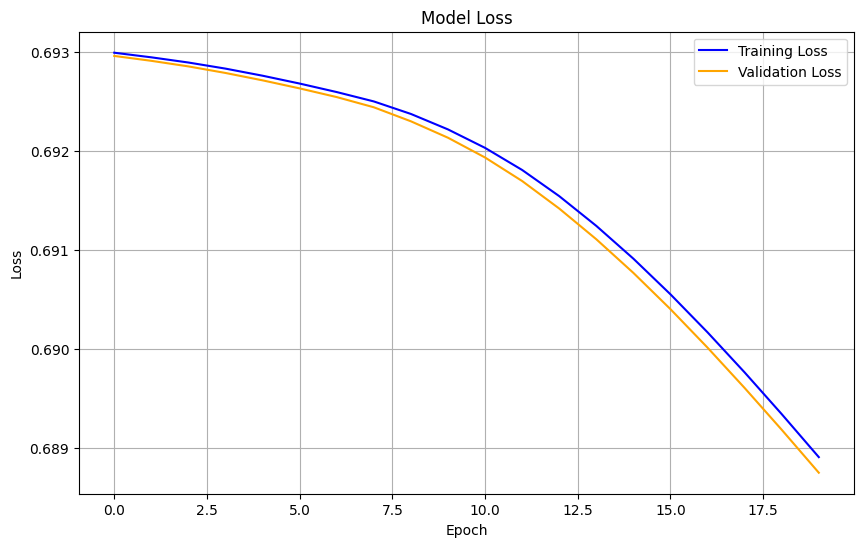

In [ ]:
# Plot loss curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 845ms/step


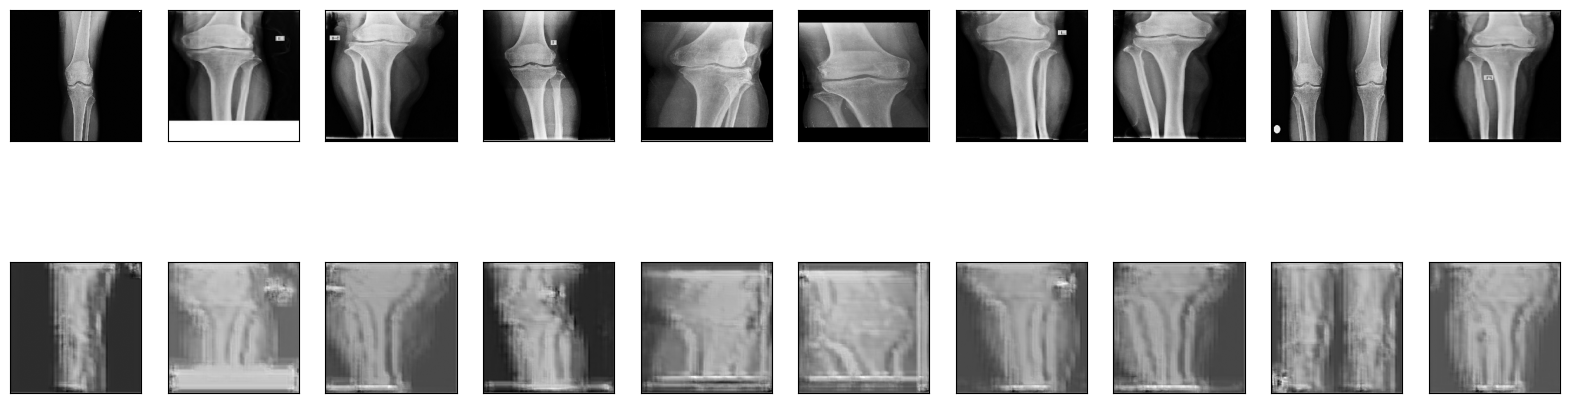

In [ ]:
# Predict reconstructed images
decoded_imgs = autoencoder.predict(X_test)

# Display original and reconstructed images
n = 10  # how many digits we will display
plt.figure(figsize=(20, 6))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_test[i].reshape(224, 224), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(224, 224), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()


Regularized autoencoder
Two types of regularization are described :

Sparse autoencoder
Denoising autoencoder


Sparse Autoencoder


In [ ]:
def load_images_from_folder(folder_path, image_size=(224, 224)):
    images = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        try:
            img = load_img(img_path, target_size=image_size, color_mode='grayscale')
            img_array = img_to_array(img).astype('float32') / 255.0
            images.append(img_array)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
    return images

dataset_path = '/content/drive/MyDrive/OS Collected Data/sample/Training'

all_images = []
for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)
    if os.path.isdir(class_path):
        all_images.extend(load_images_from_folder(class_path))

X = np.array(all_images)
X_flat = X.reshape((len(X), -1))

X_train, X_test = train_test_split(X_flat, test_size=0.2, random_state=42)


In [ ]:
input_size = X_train.shape[1]  # 224x224 = 50176

input_layer = Input(shape=(input_size,))
# Sparse Regularization added (activity_regularizer)
encoded = Dense(256, activation='relu', activity_regularizer=regularizers.l1(1e-5))(input_layer)
bottleneck = Dense(64, activation='relu')(encoded)
decoded = Dense(256, activation='relu')(bottleneck)
output_layer = Dense(input_size, activation='sigmoid')(decoded)

sparse_autoencoder = Model(inputs=input_layer, outputs=output_layer)
sparse_autoencoder.compile(optimizer='adam', loss='mse')


In [ ]:
input_size = X_train.shape[1]  # 224x224 = 50176

input_layer = Input(shape=(input_size,))
# Sparse Regularization added (activity_regularizer)
encoded = Dense(256, activation='relu', activity_regularizer=regularizers.l1(1e-5))(input_layer)
bottleneck = Dense(64, activation='relu')(encoded)
decoded = Dense(256, activation='relu')(bottleneck)
output_layer = Dense(input_size, activation='sigmoid')(decoded)

sparse_autoencoder = Model(inputs=input_layer, outputs=output_layer)
sparse_autoencoder.compile(optimizer='adam', loss='mse')


In [ ]:
history_sparse = sparse_autoencoder.fit(
    X_train, X_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, X_test)
)


Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 22s 511ms/step - loss: 0.1411 - val_loss: 0.1316
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 18s 459ms/step - loss: 0.1152 - val_loss: 0.0605
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 462ms/step - loss: 0.0575 - val_loss: 0.0587
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 470ms/step - loss: 0.0573 - val_loss: 0.0586
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 465ms/step - loss: 0.0569 - val_loss: 0.0589
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 472ms/step - loss: 0.0577 - val_loss: 0.0586
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 22s 521ms/step - loss: 0.0567 - val_loss: 0.0588
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 550ms/step - loss: 0.0583 - val_loss: 0.0589
Epoch 9/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 19s 500ms/step - loss: 0.0576 - val_loss: 0.0589
Epoch 10/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 26s 653ms/step - loss: 0.0582 - val_loss: 0.0591


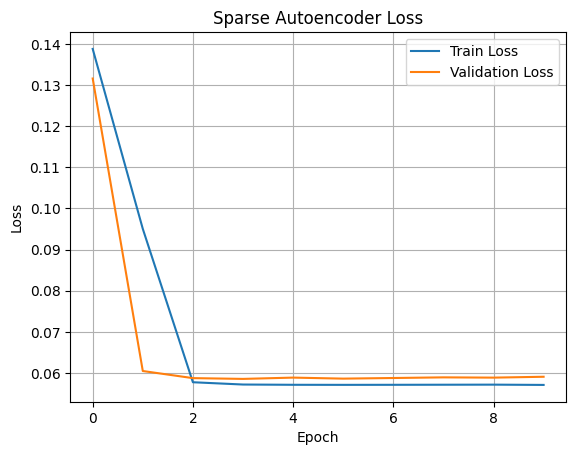

In [ ]:
plt.plot(history_sparse.history['loss'], label='Train Loss')
plt.plot(history_sparse.history['val_loss'], label='Validation Loss')
plt.title('Sparse Autoencoder Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


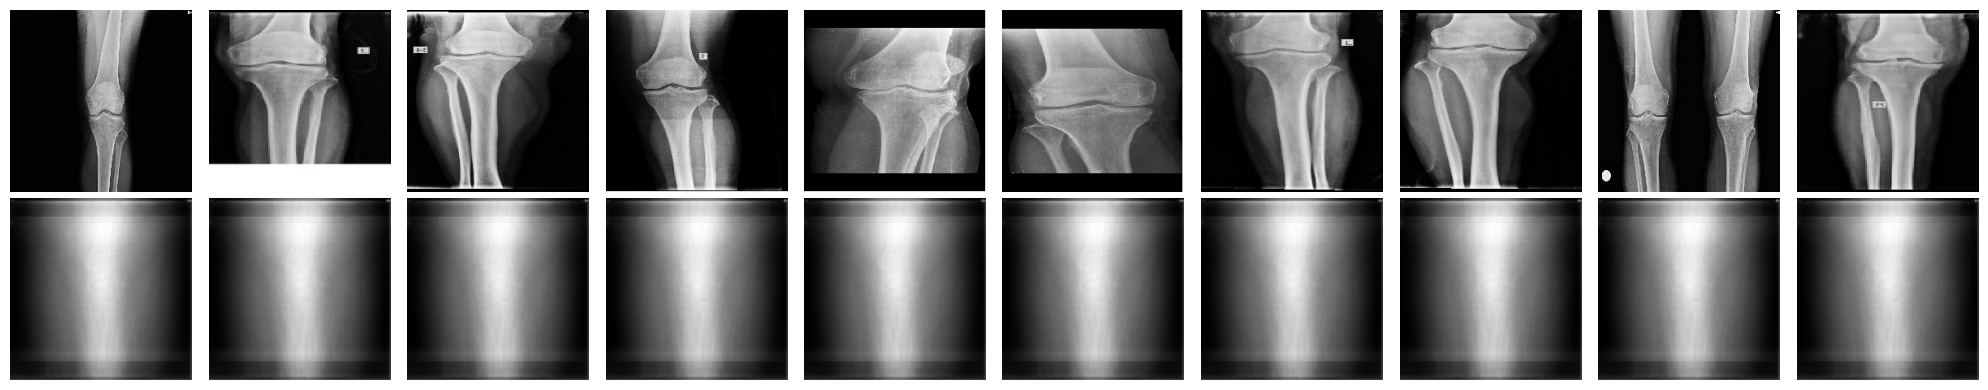

In [ ]:
decoded_imgs = sparse_autoencoder.predict(X_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_test[i].reshape(224, 224), cmap='gray')
    ax.axis('off')

    # Reconstructed
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(224, 224), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()


 Denoising Autoencoder

In [ ]:
noise_factor = 0.2

X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

# Clip the images to be between 0 and 1
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)


In [ ]:
input_layer = Input(shape=(input_size,))
encoded = Dense(512, activation='relu')(input_layer)
encoded = Dense(128, activation='relu')(encoded)
bottleneck = Dense(32, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(bottleneck)
decoded = Dense(512, activation='relu')(decoded)
output_layer = Dense(input_size, activation='sigmoid')(decoded)

denoising_autoencoder = Model(inputs=input_layer, outputs=output_layer)
denoising_autoencoder.compile(optimizer='adam', loss='mse')


In [ ]:
history_denoising = denoising_autoencoder.fit(
    X_train_noisy, X_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_noisy, X_test)
)


Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - loss: 0.0793 - val_loss: 0.0340
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - loss: 0.0306 - val_loss: 0.0219
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - loss: 0.0200 - val_loss: 0.0182
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - loss: 0.0171 - val_loss: 0.0172
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - loss: 0.0153 - val_loss: 0.0160
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - loss: 0.0142 - val_loss: 0.0146
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - loss: 0.0128 - val_loss: 0.0140
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - loss: 0.0121 - val_loss: 0.0132
Epoch 9/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - loss: 0.0113 - val_loss: 0.0130
Epoch 10/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - loss: 0.0105 - val_loss: 0.0119


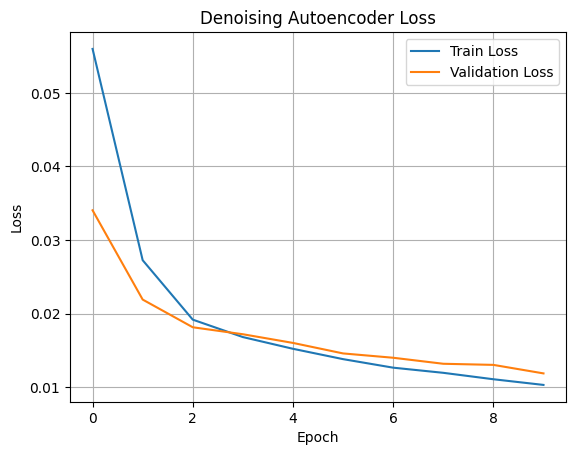

In [ ]:
plt.plot(history_denoising.history['loss'], label='Train Loss')
plt.plot(history_denoising.history['val_loss'], label='Validation Loss')
plt.title('Denoising Autoencoder Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step


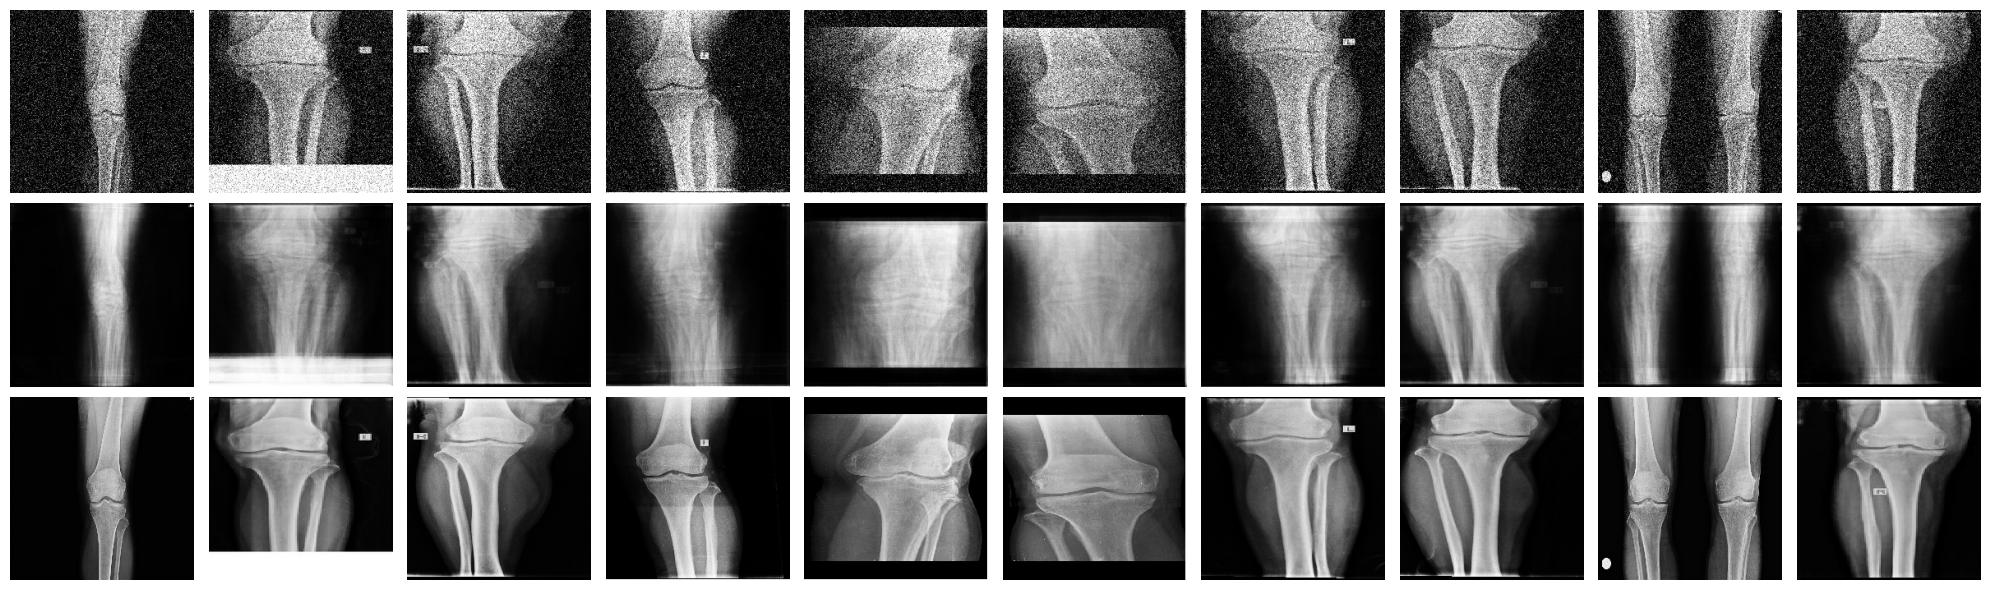

In [ ]:
decoded_imgs = denoising_autoencoder.predict(X_test_noisy)

n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display noisy
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test_noisy[i].reshape(224, 224), cmap='gray')
    ax.axis('off')

    # display reconstruction
    ax = plt.subplot(3, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(224, 224), cmap='gray')
    ax.axis('off')

    # display original
    ax = plt.subplot(3, n, i+1+2*n)
    plt.imshow(X_test[i].reshape(224, 224), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()
